In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy import dot, multiply, diag, power
import sys
sys.path.append("../src/")
from mrdmd_zscore import MrDMDZscore
import warnings
warnings.filterwarnings("ignore")

In [29]:
df_csys = pd.read_csv("../../../data/dune_data/node_selection_cpu_system.csv")

D = df_csys.iloc[:,:].to_numpy()
D = D.T
#--------------------------------------------------
# add some baselines - below I've used random values
# for actual runs use real baselines
#--------------------------------------------------
irand = np.vstack([ [random.uniform(1.14,  2.1) for b in range(max(D.shape))] for j in range(10) ])
print("random baseline",irand.shape, D.shape)
D = np.vstack([D,irand])
#--------------------------------------------------
# baselines added
#--------------------------------------------------

print(D.shape, df_csys.shape)
# extract input-output matrices
X = D[:,:-1]
Y = D[:,1:]


random baseline (10, 218559) (71, 218559)
(81, 218559) (218559, 71)


In [30]:
mrDMDZSC = MrDMDZscore()

In [57]:
%%time
ml = 13
print(D.shape)
st = time.time()
nodes1 = mrDMDZSC.mrdmd(D, max_levels=ml, max_cycles=1, do_parallel=True)
print(f"Took {time.time() - st} seconds")
len(nodes1)

(81, 218559)
Took 5.295115947723389 seconds
CPU times: user 26.5 s, sys: 32.2 s, total: 58.7 s
Wall time: 5.3 s


16383

### Below two cells not required

In [32]:
%%time
D_mrdmd = [dot(*mrDMDZSC.stitch(nodes1, i)) for i in range(ml+1)]
np.sum(D_mrdmd, axis=0).shape, D_mrdmd[0].shape

CPU times: user 58.2 s, sys: 15.3 s, total: 1min 13s
Wall time: 8.1 s


((81, 218559), (81, 218559))

(10000, 71)


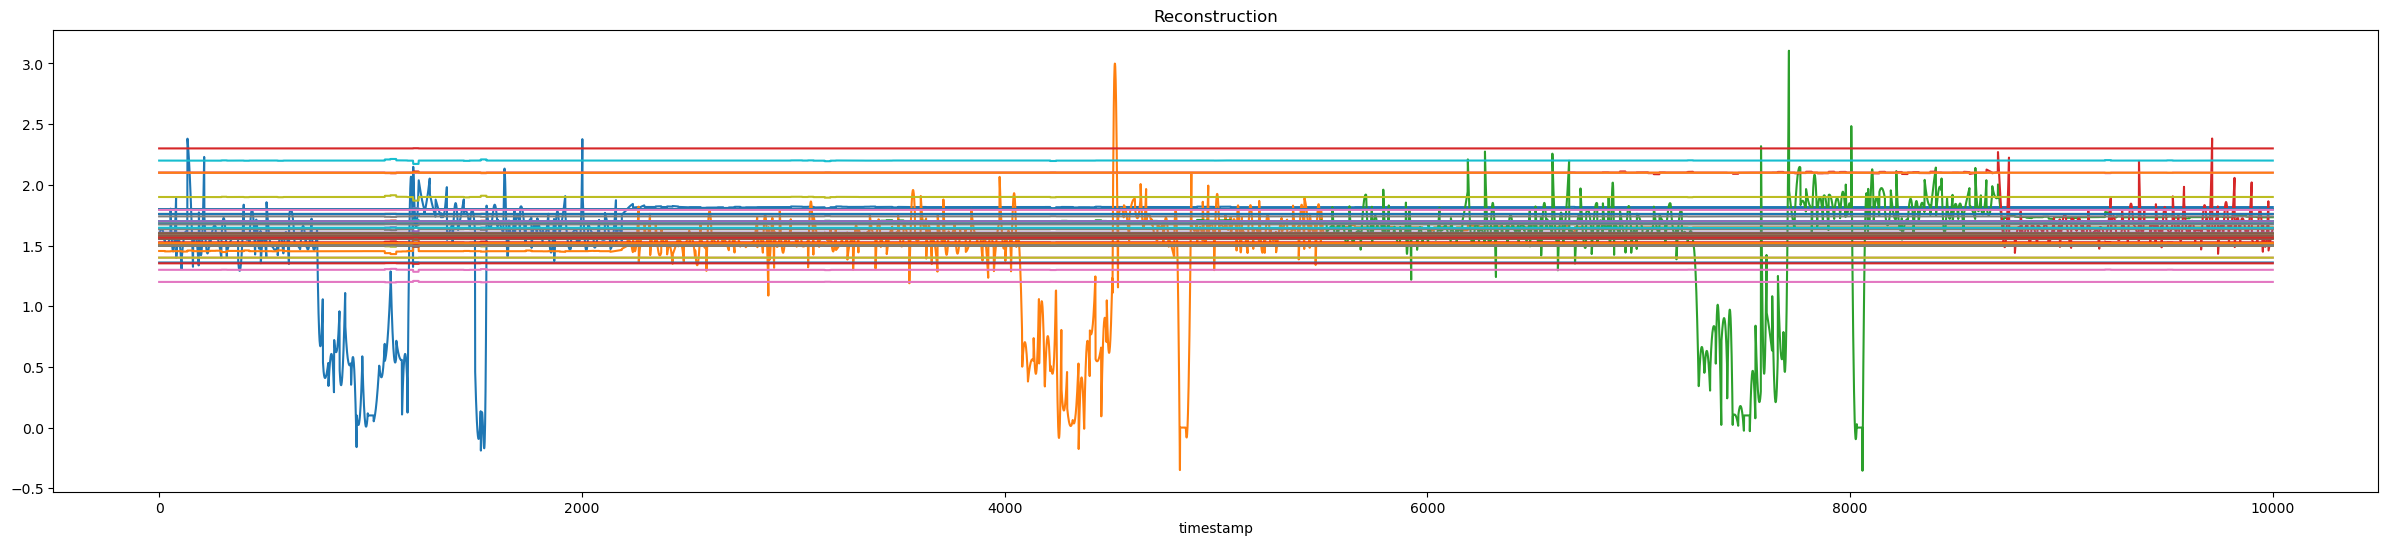

(10000, 71)


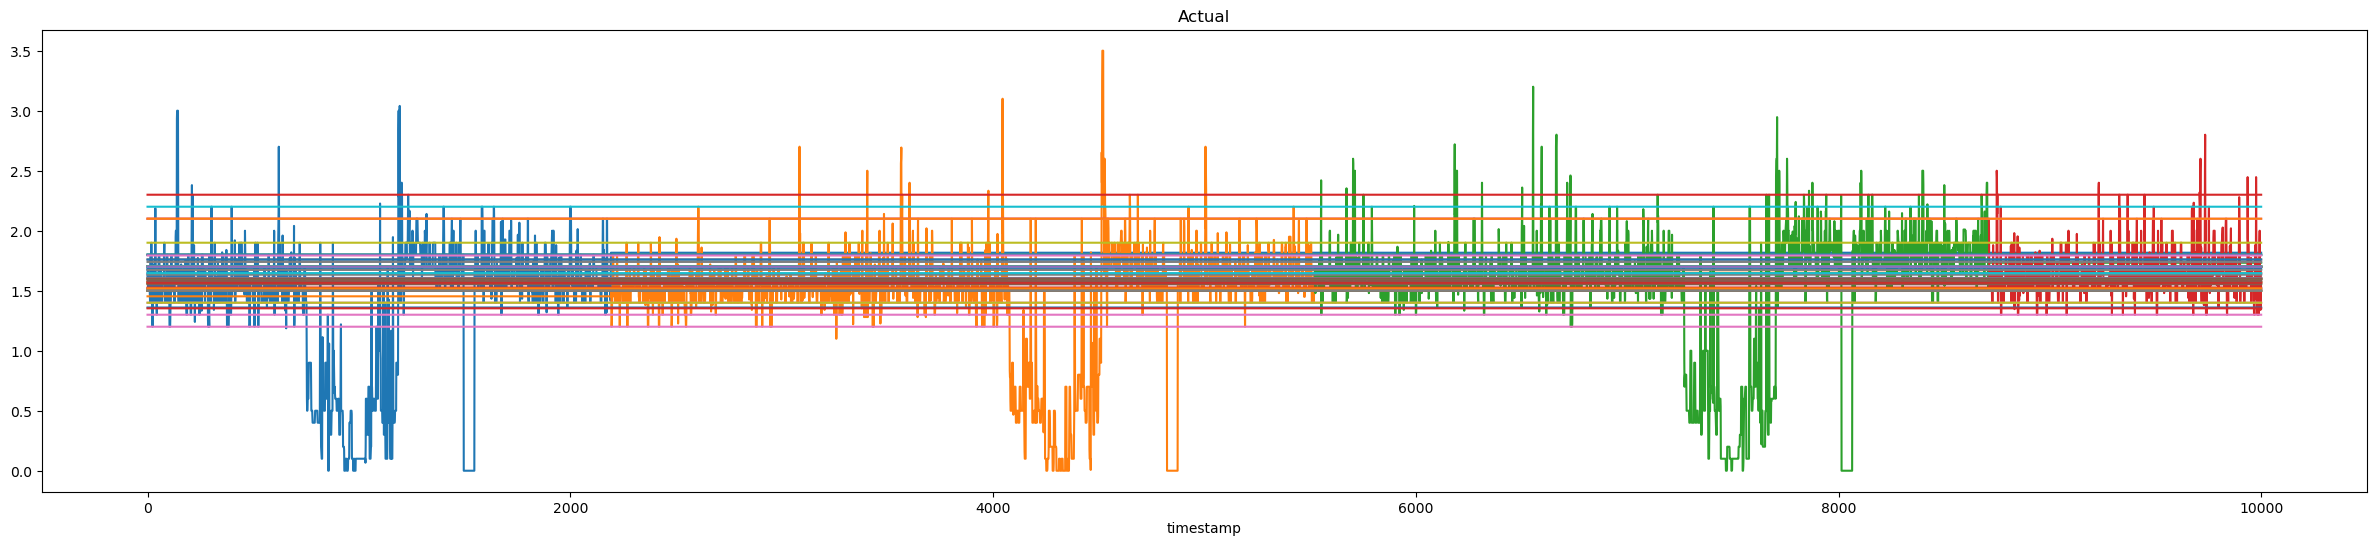

In [6]:
T = np.sum(D_mrdmd, axis=0).real
Tpd = pd.DataFrame(T).T.iloc[:10000, :]
print(Tpd.shape)
Tpd['timestamp'] = df_csys.index[:10000]
Tpd.set_index('timestamp', inplace=True)
Tpd.plot(figsize=(30,6), legend=None)
plt.title("Reconstruction")
plt.show()

# T = np.sum(D, axis=0).real
Tpd_ori = pd.DataFrame(D).T.iloc[:10000, :]
print(Tpd_ori.shape)
Tpd_ori['timestamp'] = df_csys.index[:10000]
Tpd_ori.set_index('timestamp', inplace=True)
Tpd_ori.plot(figsize=(30,6), legend=None)
plt.title("Actual")
plt.show()

### Not required done

### Zscore Analysis

In [59]:
step = 10000
data = D.copy()
data1 = data[:,:step]
max_levels=ml
splt = mrDMDZSC.get_splt(step, max_levels)
nodes = nodes1
data.shape

(81, 218559)

In [34]:
# cpu_system: 1.14 to 2.1
baselines = []
baseline_indx = []
for i in range(data.shape[0]):
    t = data[i, :]
    # print(min(t), max(t))
    if min(t) >=1.14 and max(t) <= 2.1:
        baselines.append(t)
        baseline_indx.append(i)
        c = "red" if i > 500 else "black"
        
n_baseline_indx = [nb for nb in range(data.shape[0]) if nb not in baseline_indx]
print(len(n_baseline_indx), len(baseline_indx))
baseline_indx

71 10


[71, 72, 73, 74, 75, 76, 77, 78, 79, 80]

In [35]:
# computed from previous runs with mrDMDZSC.compute_zscore(Baselines, splt, nodes, baseline_indx, n_baseline_indx, for_baseline=True)
std_baselines = 0.00366


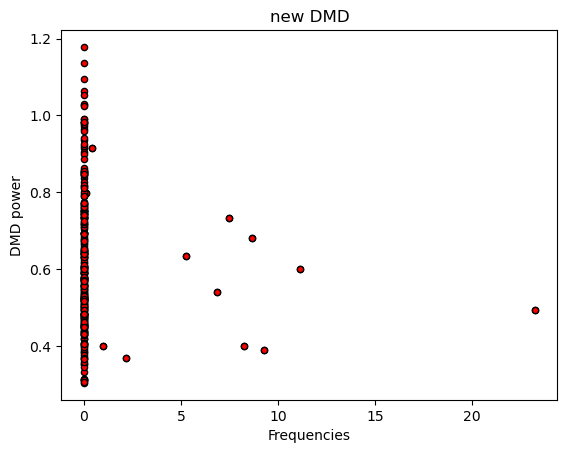

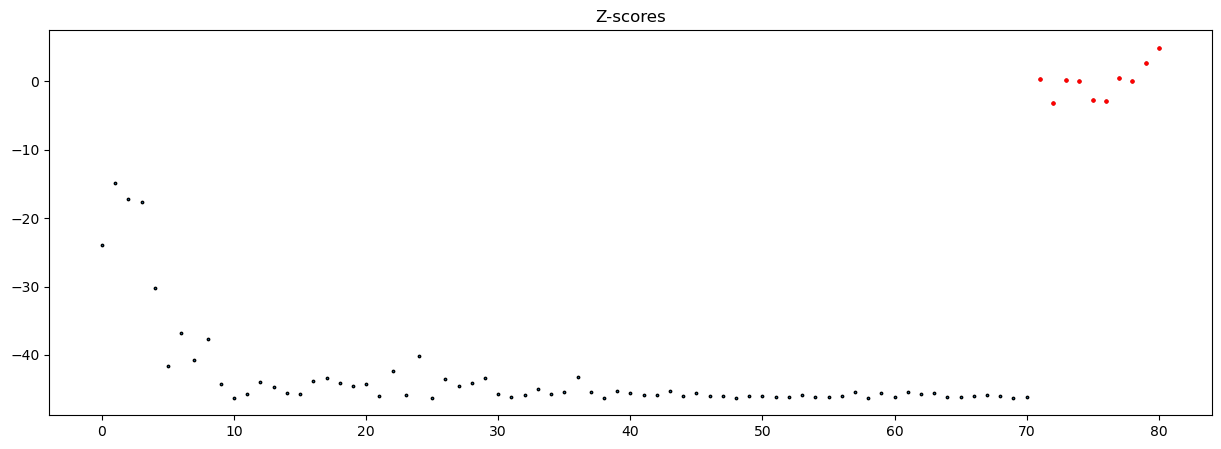

In [36]:
# to get std_baselines set for_baseline = True
# xaxis = node,  yaxis=zscore
zsc = mrDMDZSC.compute_zscore(data1, splt, nodes1, baseline_indx, n_baseline_indx, std_baselines, for_baseline=False)